<center>
    <br>
        <br>
            <br>
                <h5 style = "color:blue">====================================================================</h5>
                <h2 style = "color:green">NIPS Revise</h2>
                <h3 style = "color:green">( Naive Hayes Hyperparameter Tuning )</h3>
                <h5 style = "color:blue">====================================================================</h5>
            <br>
        <br>
    <br>
</center>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
!pip install tpot

# Step 1: Import Libraries

In [19]:
# Import Libraries

import time
import xlwt
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import mean
from numpy import sqrt
from numpy import where
from numpy import argmax
from xlwt import Workbook
from sklearn.svm import SVC
from keras.layers import Dense
from sklearn.metrics import auc
from tpot import TPOTClassifier
from collections import Counter
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn import preprocessing
from prettytable import PrettyTable 
from sklearn import model_selection
from keras.models import Sequential
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from astropy.table import Table, Column
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Step 2: Read Dataset

In [20]:
# Load Dataset

data = pd.read_excel('drive/My Drive/Colab Notebooks/WisconsinDataset/Forms_cleaned.xlsx', 'form1')

print('\n\nDataset:')
print('========\n')
data



Dataset:



,EID,FormID,Flagged,Attempt,tot_time,iresp.1,iresp.2,iresp.3,iresp.4,iresp.5,iresp.6,iresp.7,iresp.8,iresp.9,iresp.10,iresp.11,iresp.12,iresp.13,iresp.14,iresp.15,iresp.16,iresp.17,iresp.18,iresp.19,iresp.20,iresp.21,iresp.22,iresp.23,iresp.24,iresp.25,iresp.26,iresp.27,iresp.28,iresp.29,iresp.30,iresp.31,iresp.32,iresp.33,iresp.34,iresp.35,...,idur.131,idur.132,idur.133,idur.134,idur.135,idur.136,idur.137,idur.138,idur.139,idur.140,idur.141,idur.142,idur.143,idur.144,idur.145,idur.146,idur.147,idur.148,idur.149,idur.150,idur.151,idur.152,idur.153,idur.154,idur.155,idur.156,idur.157,idur.158,idur.159,idur.160,idur.161,idur.162,idur.163,idur.164,idur.165,idur.166,idur.167,idur.168,idur.169,idur.170
0,e100001,form1,0,5,10133,1,1,3.0,1,2,1.0,4,4.0,1,1,3,1.0,2,2.0,4,1.0,2,1.0,4,3,3.0,3.0,4,3,3.0,1.0,2.0,1.0,1.0,2.0,4.0,2,1,2.0,1.0,...,85,47,60,46,98,106,92,63,103,48,42,66,26,57,14,63,45,28,21,15,64,23,61,28,35,28,64,122,20,18,17,102,55,50,17,28,53,82,100,21
1,e100002,form1,1,1,12409,1,3,3.0,1,1,3.0,4,4.0,2,4,3,2.0,1,2.0,3,4.0,2,2.0,3,3,3.0,3.0,3,1,3.0,2.0,4.0,1.0,4.0,4.0,2.0,1,1,4.0,1.0,...,191,48,52,108,69,59,93,133,136,94,139,43,23,82,56,32,77,87,75,34,98,30,107,42,126,31,47,51,83,64,22,121,114,44,36,53,120,93,87,29
2,e100003,form1,1,1,12457,2,3,4.0,4,2,3.0,3,4.0,2,3,1,3.0,4,4.0,4,1.0,2,1.0,3,2,4.0,3.0,4,3,4.0,1.0,2.0,4.0,3.0,3.0,1.0,4,4,1.0,3.0,...,62,54,89,72,68,78,77,77,170,48,84,62,52,122,41,98,38,49,52,27,62,18,78,47,109,47,44,72,23,16,73,34,92,83,50,30,63,96,79,48
3,e100004,form1,1,3,11389,1,1,1.0,4,2,1.0,4,4.0,4,4,3,4.0,4,1.0,4,2.0,2,3.0,3,2,2.0,3.0,3,1,1.0,1.0,2.0,3.0,2.0,2.0,4.0,3,2,4.0,3.0,...,79,69,105,75,60,64,77,54,73,50,60,29,37,72,34,78,74,93,59,39,39,30,34,35,62,33,47,87,83,45,30,93,49,26,57,41,59,41,84,17
4,e100005,form1,1,5,13669,1,1,2.0,4,2,2.0,1,4.0,2,1,4,NaN,2,1.0,4,4.0,1,2.0,3,3,3.0,3.0,3,4,4.0,1.0,NaN,1.0,1.0,NaN,3.0,2,4,4.0,1.0,...,171,29,92,56,55,189,146,108,151,71,57,31,33,138,131,92,110,30,57,20,34,34,72,56,96,46,119,66,133,34,11,0,58,127,63,68,164,74,63,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,e101632,form1,0,1,8760,1,1,3.0,3,2,2.0,3,1.0,4,1,4,4.0,4,4.0,3,1.0,2,1.0,1,1,3.0,3.0,3,4,4.0,3.0,4.0,1.0,3.0,1.0,3.0,2,2,4.0,3.0,...,43,59,61,70,24,67,46,41,86,47,54,24,46,36,68,39,66,33,34,13,38,35,37,23,64,20,19,72,63,15,10,72,40,10,10,52,56,47,61,19
1632,e101633,form1,0,1,10568,1,1,3.0,3,2,2.0,3,1.0,1,1,4,3.0,4,4.0,3,1.0,2,1.0,1,1,3.0,3.0,3,4,4.0,3.0,1.0,1.0,3.0,1.0,3.0,2,2,4.0,3.0,...,62,42,22,26,35,44,69,69,92,79,79,18,17,48,230,58,44,90,60,18,74,49,149,14,28,38,27,128,52,8,11,116,45,11,7,116,79,59,48,40
1633,e101634,form1,0,1,12449,1,1,3.0,3,2,2.0,3,1.0,3,1,4,1.0,4,4.0,3,1.0,3,1.0,1,1,2.0,3.0,3,4,4.0,3.0,1.0,1.0,3.0,1.0,3.0,2,2,4.0,3.0,...,165,31,52,35,27,80,47,59,78,90,137,42,35,35,52,109,75,114,36,33,34,168,62,68,44,18,36,144,98,11,47,164,28,11,30,54,19,27,43,14
1634,e101635,form1,0,1,8209,1,1,3.0,3,2,2.0,3,1.0,4,1,4,3.0,2,4.0,3,1.0,2,1.0,1,1,3.0,3.0,3,4,4.0,3.0,1.0,1.0,3.0,1.0,3.0,2,2,4.0,3.0,...,42,36,12,33,26,57,49,38,123,39,90,13,41,38,17,36,41,30,26,32,50,18,69,45,30,24,27,50,24,43,14,45,32,14,28,17,18,109,94,14


# Step 3: Understand Datset

In [21]:
# Understand Dataset

print("\n\nAttributes of Dataset:")
print("======================\n")

print("\nName of Dataset: Forms_cleaned")
print("==============================\n")

print("\nNumber of Rows:", len(data))
print("====================\n")

print("\nNumber of Columns:", len(data.columns))
print("======================\n")



Attributes of Dataset:


Name of Dataset: Forms_cleaned


Number of Rows: 1636


Number of Columns: 515



# Step 4: Pre-Process Dataset

In [22]:
# Pre-Processing

data.tail()
data.drop(data.loc[:, 'iresp.1':'iresp.170'], inplace = True, axis = 1) 
data_final = data

In [23]:
# Count Null Values

print(data_final.isnull().sum())
print(data_final.shape)

EID         0
FormID      0
Flagged     0
Attempt     0
tot_time    0
           ..
idur.166    0
idur.167    0
idur.168    0
idur.169    0
idur.170    0
Length: 345, dtype: int64
(1636, 345)


In [24]:
# Drop Null Values

data_final.dropna(inplace=True)
print(data_final.isnull().sum())
print(data_final.shape)

EID         0
FormID      0
Flagged     0
Attempt     0
tot_time    0
           ..
idur.166    0
idur.167    0
idur.168    0
idur.169    0
idur.170    0
Length: 345, dtype: int64
(1636, 345)


In [25]:
# Time

data_final['mean_idur'] = data_final.loc[:, 'idur.1':'idur.170'].mean(axis=1)
data_final['median_idur'] = data_final.loc[:, 'idur.1':'idur.170'].median(axis=1)
data_final['max_idur'] = data_final.loc[:, 'idur.1':'idur.170'].max(axis=1)
data_final['min_idur'] = data_final.loc[:, 'idur.1':'idur.170'].min(axis=1)

# Correct Answers

data_final['iraw_score'] = data_final.loc[:, 'iraw.1':'iraw.170'].sum(axis=1)
data_final['iraw_score_pct'] = data_final['iraw_score']/170
data_final

,EID,FormID,Flagged,Attempt,tot_time,iraw.1,iraw.2,iraw.3,iraw.4,iraw.5,iraw.6,iraw.7,iraw.8,iraw.9,iraw.10,iraw.11,iraw.12,iraw.13,iraw.14,iraw.15,iraw.16,iraw.17,iraw.18,iraw.19,iraw.20,iraw.21,iraw.22,iraw.23,iraw.24,iraw.25,iraw.26,iraw.27,iraw.28,iraw.29,iraw.30,iraw.31,iraw.32,iraw.33,iraw.34,iraw.35,...,idur.137,idur.138,idur.139,idur.140,idur.141,idur.142,idur.143,idur.144,idur.145,idur.146,idur.147,idur.148,idur.149,idur.150,idur.151,idur.152,idur.153,idur.154,idur.155,idur.156,idur.157,idur.158,idur.159,idur.160,idur.161,idur.162,idur.163,idur.164,idur.165,idur.166,idur.167,idur.168,idur.169,idur.170,mean_idur,median_idur,max_idur,min_idur,iraw_score,iraw_score_pct
0,e100001,form1,0,5,10133,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,...,92,63,103,48,42,66,26,57,14,63,45,28,21,15,64,23,61,28,35,28,64,122,20,18,17,102,55,50,17,28,53,82,100,21,56.323529,50.0,143,14,54,0.317647
1,e100002,form1,1,1,12409,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,1,0,...,93,133,136,94,139,43,23,82,56,32,77,87,75,34,98,30,107,42,126,31,47,51,83,64,22,121,114,44,36,53,120,93,87,29,69.158824,63.0,202,11,55,0.323529
2,e100003,form1,1,1,12457,0,0,0,0,1,0,1,0,0,0,0,1,1,1,0,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,...,77,77,170,48,84,62,52,122,41,98,38,49,52,27,62,18,78,47,109,47,44,72,23,16,73,34,92,83,50,30,63,96,79,48,69.547059,65.5,179,16,61,0.358824
3,e100004,form1,1,3,11389,1,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,...,77,54,73,50,60,29,37,72,34,78,74,93,59,39,39,30,34,35,62,33,47,87,83,45,30,93,49,26,57,41,59,41,84,17,62.882353,62.0,154,12,61,0.358824
4,e100005,form1,1,5,13669,1,1,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,1,1,0,1,0,...,146,108,151,71,57,31,33,138,131,92,110,30,57,20,34,34,72,56,96,46,119,66,133,34,11,0,58,127,63,68,164,74,63,17,76.547059,69.0,189,0,62,0.364706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,e101632,form1,0,1,8760,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,...,46,41,86,47,54,24,46,36,68,39,66,33,34,13,38,35,37,23,64,20,19,72,63,15,10,72,40,10,10,52,56,47,61,19,48.658824,43.0,152,8,156,0.917647
1632,e101633,form1,0,1,10568,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,69,69,92,79,79,18,17,48,230,58,44,90,60,18,74,49,149,14,28,38,27,128,52,8,11,116,45,11,7,116,79,59,48,40,59.335294,49.0,230,7,153,0.900000
1633,e101634,form1,0,1,12449,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,47,59,78,90,137,42,35,35,52,109,75,114,36,33,34,168,62,68,44,18,36,144,98,11,47,164,28,11,30,54,19,27,43,14,69.894118,47.0,322,7,154,0.905882
1634,e101635,form1,0,1,8209,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,49,38,123,39,90,13,41,38,17,36,41,30,26,32,50,18,69,45,30,24,27,50,24,43,14,45,32,14,28,17,18,109,94,14,45.376471,34.0,258,10,152,0.894118


# Step 5: Feature Selection

In [26]:
# iraw_idur_OEF (both+OEF)

col_features = ['Attempt', 'tot_time', 'mean_idur', 'median_idur', 'max_idur', 'min_idur', 'iraw_score_pct']

for x in range(1,171):
    col_features.append('idur.'+str(x))

for i in range(1,171):
    col_features.append('iraw.'+str(i))

X = data_final.loc[:, col_features]
Y = data_final.Flagged    

In [27]:
# Count Values

counter = Counter(Y)
print(counter)

Counter({0: 1590, 1: 46})


# Step 6: Feature Scaling

In [28]:
# Scaling

scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [29]:
# SMOTE and RandomUnderSampler (for balancing data)

over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]

pipeline = Pipeline(steps=steps)

x_all, y_all = pipeline.fit_resample(X_scaled, Y)

<center>
    <br>
        <br>
            <br>
====================================================================
                <h2 >Evaluate the Performace of Naive Bayes Classifier after Parameter Tunning</h2>

                ============================================================================

</center>


=============================================================== <br>
**the best:** <br>
GaussianNB(var_smoothing=6.579332246575682e-08) <br>
=============================================================== <br>

In [30]:
def evaluate_model(data_x, data_y):
    k_fold = model_selection.KFold(n_splits = 4)

    predicted_targets = np.array([])
    actual_targets = np.array([])

    for train_ix, test_ix in k_fold.split(data_x):
        # kfold
        train_x, train_y, test_x, test_y = data_x[train_ix], data_y[train_ix], data_x[test_ix], data_y[test_ix]

        # model
        kmodel = GaussianNB(var_smoothing=6.579332246575682e-08)

        # Fit, Predict
        kmodel.fit(train_x, train_y)
        y_pred = kmodel.predict(test_x)

        predicted_targets = np.append(predicted_targets, y_pred)
        actual_targets = np.append(actual_targets, test_y)

    return predicted_targets, actual_targets



Accuracy Score:


  Accuracy:  89.68 %


Classification Report:


              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      1272
         1.0       0.84      0.85      0.85       636

    accuracy                           0.90      1908
   macro avg       0.88      0.89      0.88      1908
weighted avg       0.90      0.90      0.90      1908



Confusion Matrix:


[[1168  104]
 [  93  543]]


Confusion Matrix with Heat MAP:




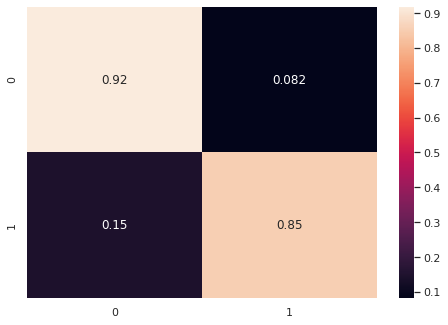

In [31]:
y_pred, y_test = evaluate_model(x_all, y_all)

# Accuracy Score
boosting_accuracy = accuracy_score(y_test, y_pred)
print("\n\n======================")
print("Accuracy Score:")
print("======================\n\n")
print("  Accuracy: ", round(boosting_accuracy*100,2), "%")

# Classification Report
report = classification_report(y_test, y_pred)
print("\n\n======================")
print("Classification Report:")
print("======================\n\n")
print(report)

# Confusion Matrix
matrix = confusion_matrix(y_test, y_pred)
print("\n\n=================")
print("Confusion Matrix:")
print("=================\n\n")
print(matrix)

# Heat Map
print("\n\n===============================")
print("Confusion Matrix with Heat MAP:")
print("===============================\n\n")
confusion_matrix_heatmap = confusion_matrix(y_test, y_pred, normalize = 'true')
sns.set(rc={'figure.figsize':(7,5)})
sns.heatmap(confusion_matrix_heatmap, annot=True)